# 3.1 MOO for 2D scalar fields

In [1]:
%matplotlib inline
import sys
import os

# Sort the paths out to run from this file
parent_path = os.path.dirname(os.getcwd())
src_path = os.path.join(os.path.sep,parent_path, 'src')
sys.path.append(src_path)
print(src_path)

/home/dharrington/cyclops/src


Setting up the objects is the same as before

In [2]:
from run_me import *


# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = GraphManager()
true_temp_field = pickle_manager.read_file('simulation', 'temp_plane_field.obj')
grid = pickle_manager.read_file('simulation', 'temp_plane_points.obj')

field_bounds = true_temp_field.get_bounds()
sensor_bounds = field_bounds+np.array([[1, 1], [-1, -1]])*0.002

In [3]:
# Setup the symmetry
symmetry_manager = SymmetryManager()
symmetry_manager.set_2D_x(np.mean(field_bounds[:, 0]))

# Setup the sensor suite
def f(x): return np.zeros(x.shape)
sensor_1 = RoundSensor(0, f, 0.1, np.array([[-5000], [5000]]), 0, 2)
sensor_2 = MultiSensor(0, f, 0.2, np.array([[-5000], [5000]]), np.linspace(sensor_bounds[0, 0], sensor_bounds[1, 0], 10).reshape(-1, 2))
sensors = np.array([sensor_1, sensor_1, sensor_1, sensor_1, sensor_1])

sensor_suite = SensorSuite(
    ScalarField(RBFModel, field_bounds), 
    sensors,
    symmetry=[symmetry_manager.reflect_2D_horiz]
)

The function names are slightly different.

In [4]:
# Setup the experiment
optimiser = NSGA2Optimiser('00:00:10')
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser
)
experiment.plan_moo(
    sensor_suite,
    sensor_bounds,
    repetitions=100,
    loss_limit=1000,
    num_cores=4
)
res = experiment.design()



# Display and save the results
for i, setup in enumerate(res.X):
    pickle_manager.save_file('results', 'Temp_2D_'+str(i)+'.obj', setup.reshape(-1, true_temp_field.get_dim()))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      1 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |             f
     3 |       60 |      1 |  1.241702E+03 |         ideal
     4 |       70 |      1 |  0.000000E+00 |             f
     5 |       80 |      1 |  0.000000E+00 |             f
     6 |       90 |      1 |  5.108202E+01 |         ideal
     7 |      100 |      1 |  0.000000E+00 |             f
     8 |      110 |      1 |  1.491796E+02 |         ideal
     9 |      120 |      1 |  1.562242E+03 |         ideal
    10 |      130 |      1 |  0.000000E+00 |             f


We only plot the graphs for the points you are interested in.

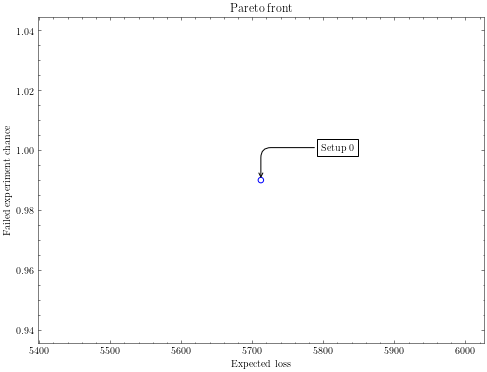


Loss: [5712.1603660284445, 0.99]


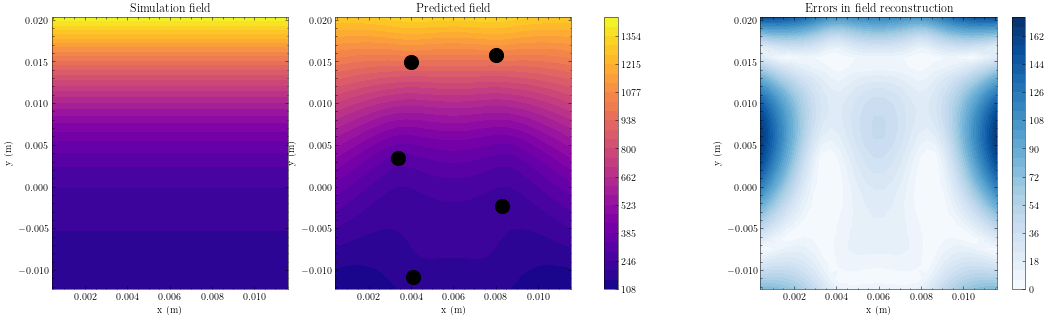

In [5]:
graph_manager.build_pareto(res.F)
graph_manager.draw()

graph_manager.build_pareto(res.F)
graph_manager.save_png('results', 'Pareto.png')

display_str = input('Enter setup to display [Q to quit]: ')
while display_str.isnumeric():
    proposed_layout, true_temps, model_temps, sensor_values = experiment.get_SOO_plotting_arrays(res.X[int(display_str)])
    print('\nLoss:', experiment.calc_MOO_loss(res.X[int(display_str)]))
    graph_manager.build_2D_compare(
        grid,
        proposed_layout,
        true_temps,
        model_temps
    )
    graph_manager.draw()
    display_str = input('Enter setup to display [Q to quit]: ')